## Sustitución por la Media/Mediana

Los métodos de imputación consisten en estimar los valores faltantes en base a los valores válidos de otras variables y/o casos de la muestra. El objectivo de cualquier método de imputación es producir **conjunto completo** que pueda ser utlizado por un algoritmo de aprendizaje de máquina (machine learning). 

La estimación se puede hacer a partir de la información del conjunto completo de variables o bien de algunas variables especialmente seleccionadas. Sustitución por la media/mediana consiste en reemplezar los valores ausentes con la media ( si la variable es normalmente distribuida) o la mediana ( si la variable tiene una distribución sesgada).

**Nota**:

- Si la variable tiene una distribución Gaussiana, la media, la mediana y la moda toman el mismo valor. Por lo tanto es equivalente, sustituir valores nulos con la media o la mediana. Sustitución por la moda, no es una práctica muy usada para las variables numéricas.
- Si la variable tiene una distribución sesgada, la media está inclinada hacia los valores que estan al extremo de la distribución. Por lo tanto, la mediana es una mejor representación de la mayoría de los valores en una variable. 
- Para las variables discretas convertidas a tipo int(casted), la media puede que no sea un número entero, por lo tanto toda la variable puede ser re-casted como 'float'. Para evitar este comportamiento, los valores faltantes pueden ser reemplazados por la media. La media siempre será un entero/ valor discreto también.


### Cuáles variables se pueden sustituir con la media/mediana?

La media y la mediana solo puede ser calculada para variables numéricas, por lo tanto estos métodos solo son apropiados para variables continuas o numéricas discretas solamente.


### Suposiciones

- Los datos faltan de forma completamente aleatoria (MCAR)
- Lo más probable es que las observaciones ausentes tengan valores como el de la mayoría de las observaciones en la variable (osea la media/mediana)

Si los datos faltan de forma completamente aleatoria, entonces es justo asumir que los valores ausentes estarán probablemente cerca a la media o la mediana de la distribución, ya que estos representes las observaciones más frecuentes/promedio. If data is missing completely at random, then it is fair to assume that the missing values, are most likely very close to the value of the mean or the median of the distribution, as these represent the most frequent / average observation.


### Ventajas

- Fácil de implementar
- Forma rápida de obtener conjuntos completos de datos
- Puede ser integrado en producción (durante el despliegue del modelo)

### Limitaciones

- Distorción de la distribución original de la variable
- Distorción de la varianza original
- Distorción de la covarianza con las otras variables en los datos.

Cuando se sustituyen los valores nulos con la media o la mediana, la varianza de la variable será distorcionada si el número de valores faltantes es grande con respecto al número total de las observaciones. 

Adicionalmente, los estimados de la covarianza y las correlaciones con las otras variables del conjunto de datos se pueden afectar ya que la media/mediana que reempleza ahora los valores faltantes no necesariamente preserva la relación con las variables restantes.

Finalmente, al concentrar todos los valores faltantes alrededor de la media/mediana, puede llevar a que observaciones que son más comunes en la distribución, pero no necesariamente son la media/mediana, se consideren como valores atípicos.

### Cuando usar la sustitución por con la media/mediana?

- Los datos faltan de forma completamente aleatoria(MCAR)
- No más del 5% de la variable esta ausente /Solo el 5% de la variable tiene datos faltantes

Aunque en teoría, las condiciones anteriores se deberían cumplir para minimizar el impacto de las técnicas de sustitución, en la práctica, estas se usan comunmente, asi los datos faltantes no sean MCAR y el porcentage de de ausencia sea alto. La razón es simple, la técnica es bastante sencilla.


### Nota final

La sustitución de valores nulos por la media/mediana se usa ampliamente en la comunindad de ciencia de datos y en varias competiciones. Por ejemplo, la solución ganadora de la copa KDD 2009 : ["Winning the KDD Cup Orange Challenge with Ensemble Selection"]( http://www.mtome.com/Publications/CiML/CiML-v3-book.pdf).

Típicamente, este tipo de sustitución se usa en conjunto con la adición de una variable binaria llamada "missing indicator" o indicador de ausencia, para capturar las observaciones donde los datos están ausentes (para más detalles ver la clase en "indicador de ausencia"). De esta forma se logran dos cosas: si los valores ausentes son realmente aleatorios, este efecto se captura por la sustitución por media/mediana y si no lo son, el efecto se captura con el indicador. Ambos métodos son fáciles de implementar, y por lo tanto son muy populares en las competencias de ciencia de datos.

## En este demo:

Vamos a aprender como implementar la sustición por la media y la mediana usando pandas y los datos Ames House Price y Titanic.

- Para bajar los datos, por favor referirse a la clase en **Datasets** en la  **Sección 1** del curso.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# dividir los datos 
from sklearn.model_selection import train_test_split

## Titanic

In [2]:
# cargar los datos del titanic con solo unas columnas

data = pd.read_csv('../titanic.csv', usecols=['age', 'fare', 'survived'])
data.head()

,survived,age,fare
0,1,29.0000,211.3375
1,1,0.9167,151.5500
2,0,2.0000,151.5500
3,0,30.0000,151.5500
4,0,25.0000,151.5500


In [3]:
# porcentage de valores faltantes
data.isnull().mean()

survived    0.000000
age         0.200917
fare        0.000764
dtype: float64

La única variable con valores ausentes es age, con ~20% de valores nulos.

### Para tener en cuenta

Sustitución se debe hacer en el segmento usado para entrenar el modelo, y luego deber ser propagado en el segmento de prueba. Esto significa que el mismo valor de media/mediana deber ser usado para sustituir los valores ausentes en ambos segmentos - entrenamiento y prueba, pero dicho valor se calcula solamente del segmento de entrenamiento. La razón principal es para evitar sobre-ajustes pero tambien para preservar la distribución original de los datos usados para modelamiento, que se supone es representativa de los datos que se usaran para evaluar el modelo o los datos una vez en producción.


In [4]:
# separemos datos para modelamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(
    data[['age', 'fare']],  # predictors
    data['survived'],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((916, 2), (393, 2))

In [5]:
# exploremos datos nulos en el segmento de entrenamiento
# el porcentaje debe ser similar que para todo el 
# conjunto de datos

X_train.isnull().mean()

age     0.191048
fare    0.000000
dtype: float64

In [6]:
# creemos una función para sustituir los valores faltantes
# con la media o la mediana
# la función toma como argumentos:
# dataframe, variable, y el valor de media/mediana
# retorna la variable con los valores sustituidos

def impute_na(df, variable, mean_median):

    return df[variable].fillna(mean_median)

In [7]:
# calcular la mediana Age

median = X_train.age.median()
median

28.0

In [8]:
# calcular la media de  Age

mean = X_train.age.mean()
mean

30.23144399460189

In [9]:
# creemos una nueva variable con los valores nulos reemplazados

# primero reemplazar con la mediana 
X_train['age_median'] = impute_na(X_train, 'age', median)

# ahora reemplazar con la media
X_train['age_mean'] = impute_na(X_train, 'age', mean)

# la media contiene muchos decimales, redondeemos a 1 dígito
# usando la funcion de numpy
X_train['age_mean'] = np.round(X_train['age_mean'], 1)

X_train.head(15)

,age,fare,age_median,age_mean
501,13.0,19.5000,13.0,13.0
588,4.0,23.0000,4.0,4.0
402,30.0,13.8583,30.0,30.0
1193,NaN,7.7250,28.0,30.2
686,22.0,7.7250,22.0,22.0
971,NaN,7.8792,28.0,30.2
117,30.0,56.9292,30.0,30.0
540,2.0,26.0000,2.0,2.0
294,49.0,110.8833,49.0,49.0
261,35.0,26.2875,35.0,35.0


Miremos a las filas con valores nulos (NaN) en age, y comparemos con las nuevas variables con los valores sustituidos por ya sea la media 29 o la media 29.9


In [10]:
# vemos como la varianza cambia luego de la sustitución
# esto es de esperarse, porque el porcentaje de valores ausentes 
# es relativamente grande en age, ~20%

print('Varianza variable original: ', X_train['age'].var())
print('Varianza luego de sustitución por mediana: ', X_train['age_median'].var())
print('Varianza luego de sustitución por media: ', X_train['age_mean'].var())

Varianza variable original:  194.16304666581863
Varianza luego de sustitución por mediana:  157.79842957602128
Varianza luego de sustitución por media:  157.0217073519937


La varianza es subestimada, porque ahora muchas observaciones tienen el mismo valor en age (ya sea la media o mediana)


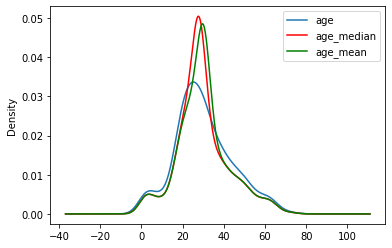

In [11]:
# Comparemos distribuciones

fig = plt.figure()
ax = fig.add_subplot(111)

# distribución original de la variable
X_train['age'].plot(kind='kde', ax=ax)

# distribución variable sustituida con mediana
X_train['age_median'].plot(kind='kde', ax=ax, color='red')

# distribución variable sustituida con media
X_train['age_mean'].plot(kind='kde', ax=ax, color='green')

# etiquetas 
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

La distribución de la variable cambia, ya que ahora hay muchos más valores acumulados hacia la media o mediana.

**Es esto importante?**

Depende del modelo de machine learning que se quiera construir. Los modelos lineales asumen que las variables están normalmente distribuidas. La sustitución por la media/mediana puede distorcionar la distribución normal original si el porcentaje de valores ausentes es alto y por lo tanto afectar el desempeno del modelo lineal.


In [12]:
# la sustitución por media / mediana tambien puede afectar
# la relación con las otras variables en los datos

X_train[['fare', 'age', 'age_median', 'age_mean']].cov()

,fare,age,age_median,age_mean
fare,2248.326729,136.176223,114.961682,110.198311
age,136.176223,194.163047,194.163047,194.159033
age_median,114.961682,194.163047,157.798430,157.035694
age_mean,110.198311,194.159033,157.035694,157.021707


Podemos ver que la covarianza entre age y fare ha cambiado luego de la sustitución


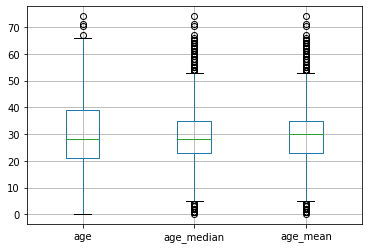

In [13]:
# Finalmente, la sustitución por media / mediana tambien puede
# generar observaciones que siendo completamente normales parecen
# valores extramos

# o en otras palabras la sustitución puede incrementar
# el número percibido de valores extremos

# analicemos la gráfica de caja

X_train[['age', 'age_median', 'age_mean']].boxplot()

De la gráfica anterior, podemos ver después de la sustitución hay mas valores extremos hacia los valores altos de age, pero tambien para los valores inferiores.

**Es esto importante?**

Si queremos identificar los verdaderos valores extremos, es importante tener en cuenta este comportamiento. En la práctica, este tipo de efectos son ignorados, pero es importante saber que esta sucediendo. Si es necesario, el orden de los pasos en el pre-procesamiento puede adaptarse para tener en cuenta este tipo de efectos.

## House Prices Dataset

Repitamos rápidamente el mismo ejercicio con el House Prices dataset.

In [14]:
# usaremos las siguientes variables, de las cuales solo 3 
# tienen variables con valores nulos

cols_to_use = [
    'OverallQual', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'WoodDeckSF',
    'BsmtUnfSF', 'LotFrontage', 'MasVnrArea', 'GarageYrBlt', 'SalePrice'
]

In [15]:
# House Prices dataset

data = pd.read_csv('../houseprice.csv', usecols=cols_to_use)
print(data.shape)
data.head()

(1460, 10)


,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice
0,65.0,7,196.0,150,856,856,1710,2003.0,0,208500
1,80.0,6,0.0,284,1262,1262,1262,1976.0,298,181500
2,68.0,7,162.0,434,920,920,1786,2001.0,0,223500
3,60.0,7,0.0,540,756,961,1717,1998.0,0,140000
4,84.0,8,350.0,490,1145,1145,2198,2000.0,192,250000


In [16]:
# variables con valores nulos

# en la siguiente list comprehension, iteraremos sobre las columnas
# y seleccionaremos las que contienen valores nulos

[var for var in data.columns if data[var].isnull().sum() > 0]

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']

In [17]:
# porcentaje de valores nulos

data[['LotFrontage', 'MasVnrArea', 'GarageYrBlt']].isnull().mean()

LotFrontage    0.177397
MasVnrArea     0.005479
GarageYrBlt    0.055479
dtype: float64

**Recuerda que el mean y la mediana que usaremos para sustituir los valores nulos deben ser calculados del segemento de entrenamiento y propagados para el segmento de prueba.


In [18]:
# separemos los datos en entrenamiento y prueba

X_train, X_test, y_train, y_test = train_test_split(data,
                                                    data['SalePrice'],
                                                    test_size=0.3,
                                                    random_state=0)
X_train.shape, X_test.shape

((1022, 10), (438, 10))

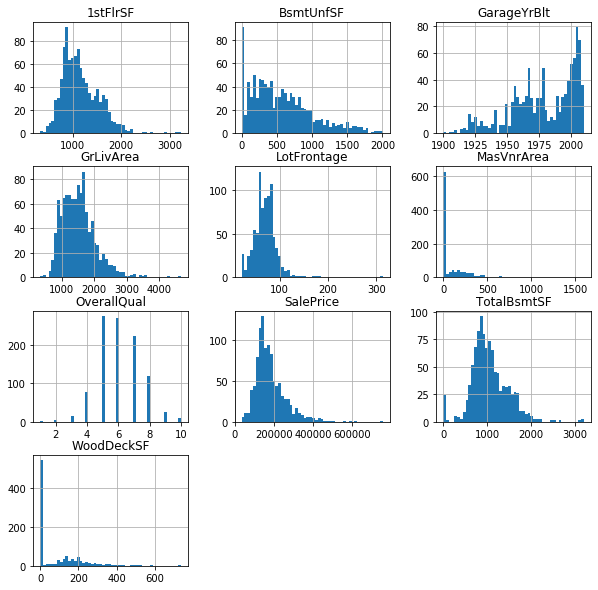

In [19]:
# distribuciones de las variables
X_train.hist(bins=50, figsize=(10,10))
plt.show()

In [20]:
# vamos a crear una nueva variable sustituyendo los valores nulos
# con la mediana para cada una de las variables con valores ausentes.

# empecemos con la variable LotFrontage

median = X_train['LotFrontage'].median()

X_train.loc[:,'LotFrontage_median'] = impute_na(X_train, 'LotFrontage', median)
X_test.loc[:,'LotFrontage_median'] = impute_na(X_test, 'LotFrontage', median)

/Users/natisangarita/python/courses/feml/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/natisangarita/python/courses/feml/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [21]:
median = X_train['MasVnrArea'].median()

X_train.loc[:,'MasVnrArea_median'] = impute_na(X_train, 'MasVnrArea', median)
X_test.loc[:,'MasVnrArea_median'] = impute_na(X_test, 'MasVnrArea', median)

In [22]:
median = X_train['GarageYrBlt'].median()

X_train.loc[:, 'GarageYrBlt_median'] = impute_na(X_train, 'GarageYrBlt', median)
X_test.loc[:,'GarageYrBlt_median'] = impute_na(X_test, 'GarageYrBlt', median)

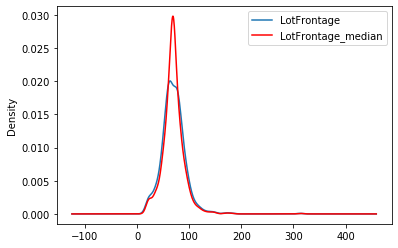

In [23]:
# evaluemos el efecto de la sustitución en las distribuciones

# Más valores se acumular hacia la mediana en la 
# distribución de LotFrontAge


fig = plt.figure()
ax = fig.add_subplot(111)

# distribución original
X_train['LotFrontage'].plot(kind='kde', ax=ax)

# variable sustituida con la mediana
X_train['LotFrontage_median'].plot(kind='kde', ax=ax, color='red')

# etiquetas
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

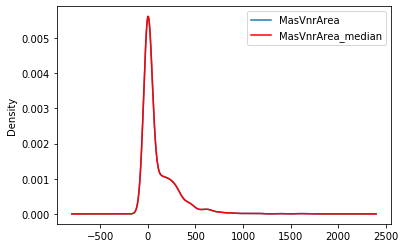

In [24]:
# For MasVnrArea, because the percentage of missing data
# was low, we don't expect and won't see a dramatic change in the
# original distribution of the variable

fig = plt.figure()
ax = fig.add_subplot(111)

# original variable distribution
X_train['MasVnrArea'].plot(kind='kde', ax=ax)

# variable imputed with the median
X_train['MasVnrArea_median'].plot(kind='kde', ax=ax, color='red')

# add legends
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

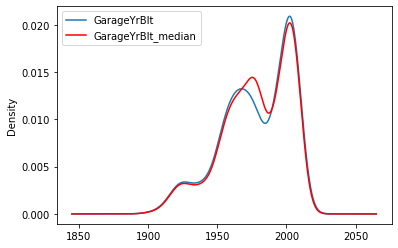

In [25]:
# Para la variable GarageBlt, dado que el porcentaje de valores nulos
# es menor, no hay un cambio significativo en la distribución

fig = plt.figure()
ax = fig.add_subplot(111)

# distribución original
X_train['GarageYrBlt'].plot(kind='kde', ax=ax)

# variable sustitiuida por la mediana
X_train['GarageYrBlt_median'].plot(kind='kde', ax=ax, color='red')

# etiquetas
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

In [26]:
# efecto de la sustitución en la varianza

# Para LotFrontAge hay un cambio significativo ya que el porcetaje
# de valores nulos es alto~20%

print('Varianza original : ', X_train['LotFrontage'].var())
print('Varianza despues de sustitución por mediana: ', X_train['LotFrontage_median'].var())

Varianza original :  532.5872021885677
Varianza despues de sustitución por mediana:  434.0660426541647


In [27]:
# no hay cambios significativo para MasnVnrArea, ya que el % de valores nulos es bajo
print('Varianza original: ', X_train['MasVnrArea'].var())
print('Varianza despues de sustitución por mediana: ', X_train['MasVnrArea_median'].var())

Varianza original:  32983.53871003956
Varianza despues de sustitución por mediana:  32874.27007404199


In [28]:
# no hay cambios significativo para GarageBlt, ya que el % de valores nulos es bajo

print('Varianza original: ', X_train['GarageYrBlt'].var())
print('Varianza despues de sustitución por mediana: ', X_train['GarageYrBlt_median'].var())

Varianza original:  624.3059475074142
Varianza despues de sustitución por mediana:  591.3356883144761


In [29]:
# Exploremos la covarianza:
# tómate el tiempo de comparar los valores en la tabla
# y observa cómo la covarianza es afectada por LotFrontAge pero no mucho 
# por las otras dos variables
X_train.cov()

,LotFrontage,OverallQual,MasVnrArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,GrLivArea,GarageYrBlt,WoodDeckSF,SalePrice,LotFrontage_median,MasVnrArea_median,GarageYrBlt_median
LotFrontage,532.587202,6.587119,6.805603e+02,9.496573e+02,2.908856e+03,3.379794e+03,3.919952e+03,30.611717,1.347414e+02,6.689645e+05,532.587202,6.744233e+02,28.095264
OverallQual,6.587119,1.843859,1.014970e+02,1.746147e+02,2.886241e+02,2.242973e+02,4.091242e+02,17.902809,3.168557e+01,8.320132e+04,5.384774,1.005330e+02,16.875386
MasVnrArea,680.560330,101.496976,3.298354e+04,7.540788e+03,2.478877e+04,2.086595e+04,3.520785e+04,1203.583792,3.208924e+03,6.836439e+06,553.921303,3.298354e+04,1134.380889
BsmtUnfSF,949.657293,174.614725,7.540788e+03,1.875241e+05,7.513307e+04,4.987449e+04,5.203392e+04,1823.065167,-1.833201e+03,6.833028e+06,788.095358,7.472110e+03,1724.141544
TotalBsmtSF,2908.855504,288.624075,2.478877e+04,7.513307e+04,1.682931e+05,1.212079e+05,8.615192e+04,3173.042442,1.227966e+04,2.003928e+07,2370.929189,2.465436e+04,2989.473391
1stFlrSF,3379.793504,224.297266,2.086595e+04,4.987449e+04,1.212079e+05,1.398656e+05,1.044401e+05,2009.195552,1.109406e+04,1.783631e+07,2750.747094,2.080136e+04,1890.271636
GrLivArea,3919.951834,409.124216,3.520785e+04,5.203392e+04,8.615192e+04,1.044401e+05,2.681277e+05,2738.982988,1.558395e+04,2.934477e+07,3189.685753,3.496714e+04,2576.345636
GarageYrBlt,30.611717,17.902809,1.203584e+03,1.823065e+03,3.173042e+03,2.009196e+03,2.738983e+03,624.305948,6.658911e+02,9.309355e+05,24.755173,1.182673e+03,624.305948
WoodDeckSF,134.741376,31.685571,3.208924e+03,-1.833201e+03,1.227966e+04,1.109406e+04,1.558395e+04,665.891118,1.648582e+04,3.029981e+06,106.009105,3.212101e+03,627.624634
SalePrice,668964.454191,83201.317781,6.836439e+06,6.833028e+06,2.003928e+07,1.783631e+07,2.934477e+07,930935.489321,3.029981e+06,6.105731e+09,544838.836893,6.790442e+06,877485.418108


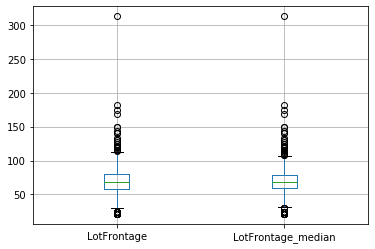

In [30]:
# Exploremos los valores extremos

# hay una disminución en los límites para LotFrontage
# (mira el tamano de la caja) 
# pero no sucede para las otras dos variables

X_train[['LotFrontage', 'LotFrontage_median']].boxplot()

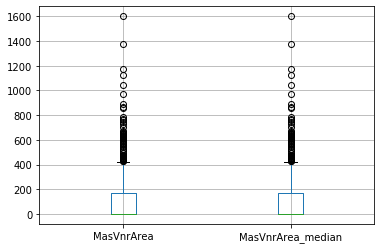

In [31]:
X_train[['MasVnrArea', 'MasVnrArea_median']].boxplot()

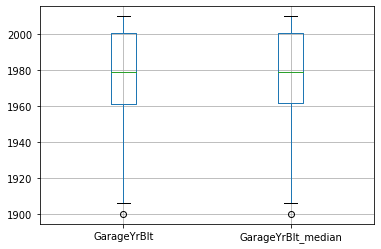

In [32]:
X_train[['GarageYrBlt', 'GarageYrBlt_median']].boxplot()

**Eso es todo por este demo**.

Hacia el final de esta sección, mostraremos como usar la sustitución usando paquete de open source de python, como parte de un pipeline de machine learning.
